# QAOA for solving MaxCut problem

The Quantum Approximate Optimization Algorithm (QAOA) is a quantum algorithm for solving combinatorial optimization problems. The MaxCut problem is one such problem, where the goal is to divide the vertices of a graph into two groups such that the number of edges between the groups is maximized.

In the context of quantum computing, QAOA is used to find the optimal solution by preparing a quantum state that represents the solution to the problem. The algorithm involves applying a series of quantum gates to a quantum circuit, and then measuring the output. The parameters of the quantum gates are optimized using a classical optimization algorithm to find the solution that maximizes the objective function.

!pip install qiskit

In [82]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [121]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize

In [122]:
backend = Aer.get_backend('qasm_simulator')

## 5-vertices graph

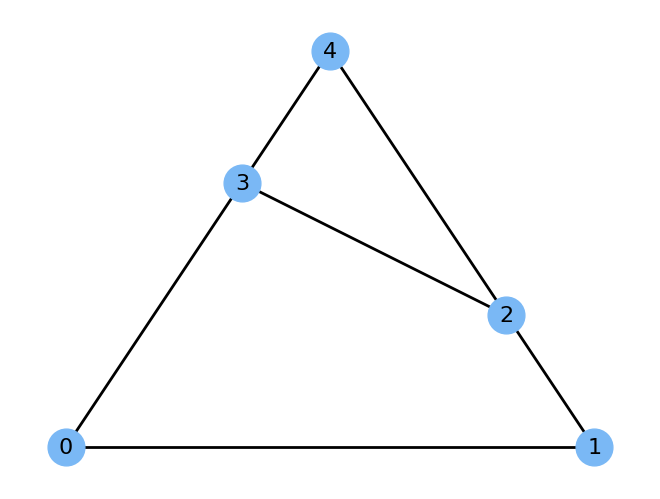

In [123]:
G = nx.Graph()
G.add_edges_from([[0, 1], [1, 2], [0, 3], [2, 3], [3, 4], [2, 4]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.planar_layout(G))

In [124]:
def C_operator_gates(G, alpha):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n)
    for i, j in G.edges():
        qc.cx(i, j)
        qc.rz(alpha* 2, j)
        qc.cx(i, j)
    return qc

In [126]:
qc = C_operator_gates(G, np.pi/2)
qc.draw()

»
q_0: ──■─────────────■────■──────────────────────■──────────────────────────»
     ┌─┴─┐┌───────┐┌─┴─┐  │                      │                          »
q_1: ┤ X ├┤ Rz(π) ├┤ X ├──┼──────■───────────────┼────■─────────────────────»
     └───┘└───────┘└───┘  │    ┌─┴─┐  ┌───────┐  │  ┌─┴─┐                   »
q_2: ─────────────────────┼────┤ X ├──┤ Rz(π) ├──┼──┤ X ├──■─────────────■──»
                        ┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐└───┘┌─┴─┐┌───────┐┌─┴─┐»
q_3: ───────────────────┤ X ├┤ Rz(π) ├─────────┤ X ├─────┤ X ├┤ Rz(π) ├┤ X ├»
                        └───┘└───────┘         └───┘     └───┘└───────┘└───┘»
q_4: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«                                           
«q_0: ──────────────────────────────────────
«                                           
«q_1: ──────────────────────────────────────
«                                           
«q_2: ──■─────────────■─────────────────────
«       │             │                     
«q_3: ──┼─────────────┼────■─────────────■──
«     ┌─┴─┐┌───────┐┌─┴─┐┌─┴─┐┌───────┐┌─┴─┐
«q_4: ┤ X ├┤ Rz(π) ├┤ X ├┤ X ├┤ Rz(π) ├┤ X ├
«     └───┘└───────┘└───┘└───┘└───────┘└───┘

In [127]:
def B_operator_gates(G, beta):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n,n)
    
    for node in G.nodes():
        qc.rx(2*beta, node)
        
    return qc


In [128]:
qc = B_operator_gates(G, np.pi/2)
qc.draw()

┌───────┐
q_0: ┤ Rx(π) ├
     ├───────┤
q_1: ┤ Rx(π) ├
     ├───────┤
q_2: ┤ Rx(π) ├
     ├───────┤
q_3: ┤ Rx(π) ├
     ├───────┤
q_4: ┤ Rx(π) ├
     └───────┘
c: 5/═════════

The QAOA algorithm has two main steps:

* Prepare an initial state of n qubits in the superposition state.
* Apply the QAOA ansatz with a certain depth p. The ansatz is a sequence of unitary operators that depend on a set of parameters. These parameters are optimized to minimize the expectation value of the cost function.

In [129]:
def create_full_circuit(G, alpha, beta):
    n = G.number_of_nodes()
    qc = QuantumCircuit(n,n)

    qc.h(range(n))
    
    qc = qc.compose(C_operator_gates(G, alpha))
    qc = qc.compose(B_operator_gates(G, beta))
    
    qc.barrier(range(n))
    qc.measure(range(n), range(n))
    
    return qc

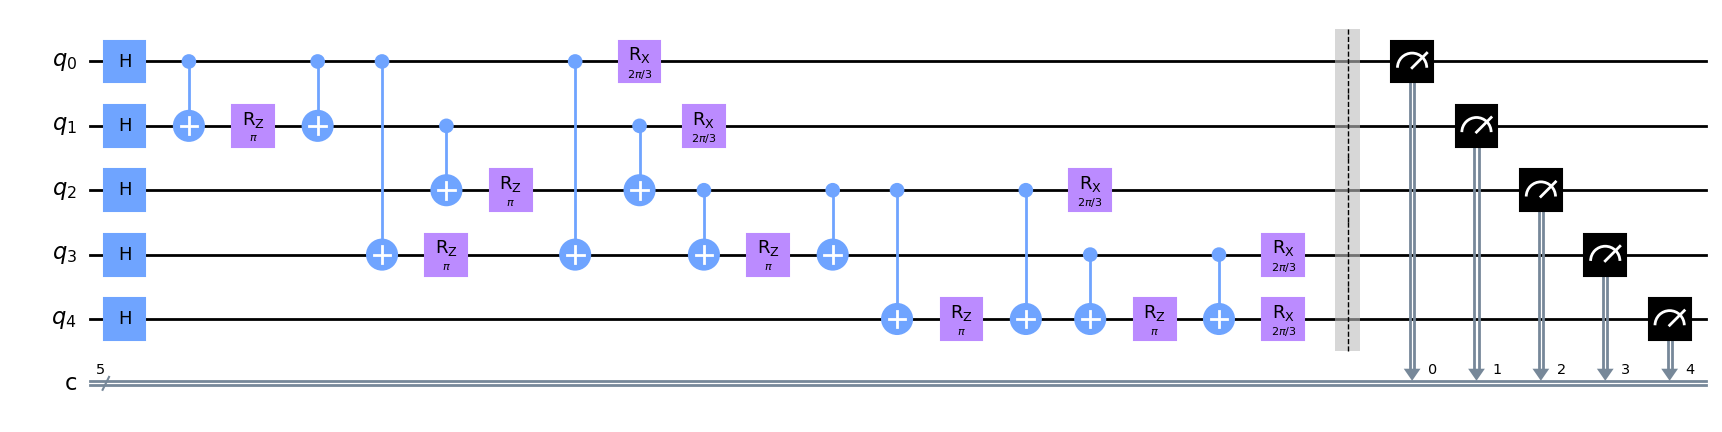

In [131]:
qc_5 = create_full_circuit(G, np.pi/2, np.pi/3)
qc_5.draw('mpl')

In [132]:
# helper function to change the orfer of bits returned from Qiskit
def change_order_of_bits(frequencies):
    return {state[::-1]:frequencies for state, frequencies in frequencies.items()}

Distribution of states before optimization


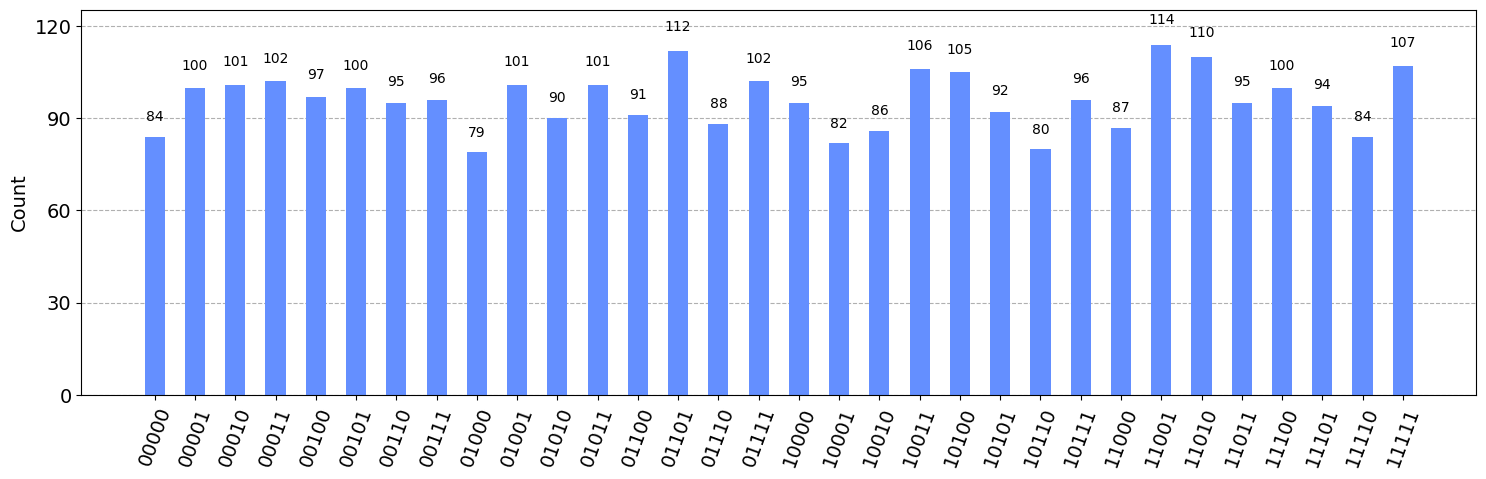

In [133]:
job = execute(qc_5, backend, shots = 3072)
frequencies = change_order_of_bits(job.result().get_counts())
plot_histogram(frequencies, figsize=(18, 5))

In [134]:
def get_cut_size_from_state_string(G, state):
    cut = 0
    
    for i, j in G.edges():
        if state[i] != state[j]:
            cut += 1
    return cut

In [135]:
def get_average_energy(G, frequencies):
    total_energy = 0
    total_frequencies = 0
    
    for state, frequence in frequencies.items():
        total_energy -= get_cut_size_from_state_string(G, state) * frequence
        total_frequencies += frequence
    avg_energy = total_energy / total_frequencies
    
    return avg_energy

In [136]:
def get_most_frequent_state(frequencies):
    state =  max(frequencies, key=lambda x: frequencies[x])
    
    return state

In [137]:
def get_exact_maxcut(G, frequencies):
    states = [(get_cut_size_from_state_string(G, state), state) for state in frequencies.keys()]
    maxcut, maxcut_state = max(states, key = lambda x: x[0])
    
    return maxcut, maxcut_state

In [138]:
def get_cost_function(G):
    def cost_function(theta):
        #alpha = theta[1:]
        #beta = theta[:1]
        alpha = theta[1:][0]
        beta = theta[:1][0]
        
        qc = create_full_circuit(G, alpha, beta)
        frequencies = execute(qc, backend, shots=3072, seed_simulator=7).result().get_counts()

        return get_average_energy(G, change_order_of_bits(frequencies))
    return cost_function

In [139]:
def minimize_cost_function(G, init_point):
    cost = get_cost_function(G)
    np_init_point = np.array(init_point)
    result = minimize(cost, np_init_point, method='COBYLA', options={'maxiter':3500, 'disp': True})
    return result

In [140]:
def get_frequencies_for_optimal_cirquit(G, minimization_result):
    params = minimization_result['x']
    qc = create_full_circuit(G, params[1:][0], params[:1][0])
    frequencies = change_order_of_bits(execute(qc, backend, shots=20000).result().get_counts())
    
    return frequencies

In [141]:
result = minimize_cost_function(G, [np.pi/2, np.pi/3])
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.49609375
       x: [ 4.554e-01  1.030e+00]
    nfev: 40
   maxcv: 0.0

Distribution of states after optimization

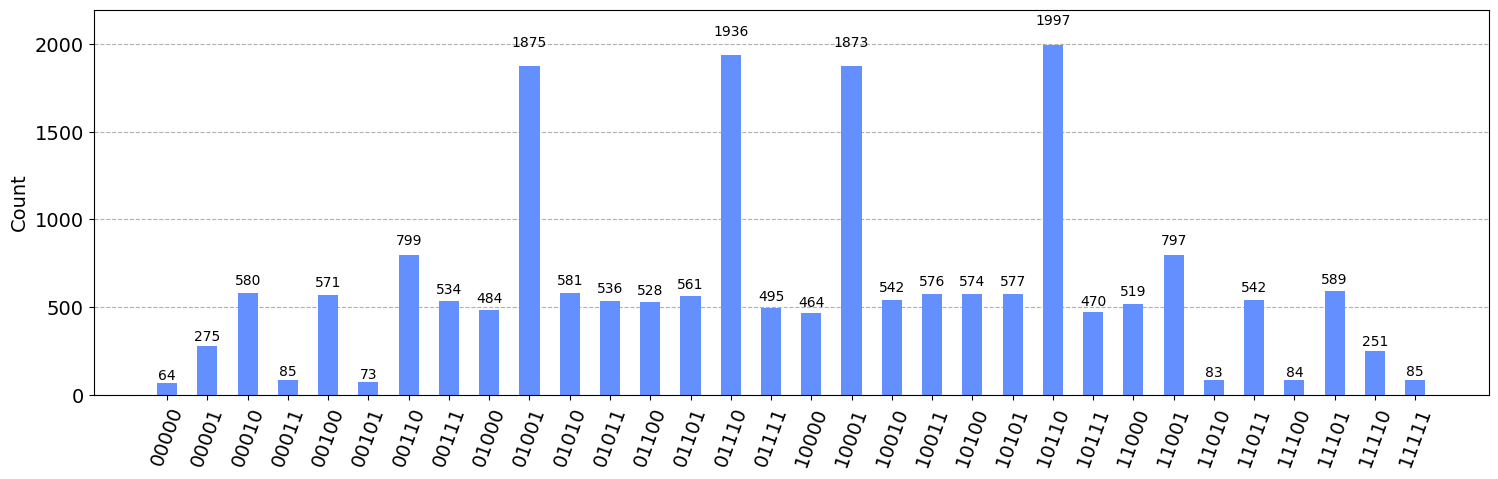

In [142]:
frequencies = get_frequencies_for_optimal_cirquit(G, result)

plot_histogram(frequencies, figsize=(18, 5))

In [143]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 10110 with cut size 4
Exact max cut size: 5
Average cut size from all executions:  3.4937


The output of the algorithm is a bitstring that represents the solution to the MaxCut problem. The quality of the solution depends on the number of iterations (or "depth") used in the algorithm.

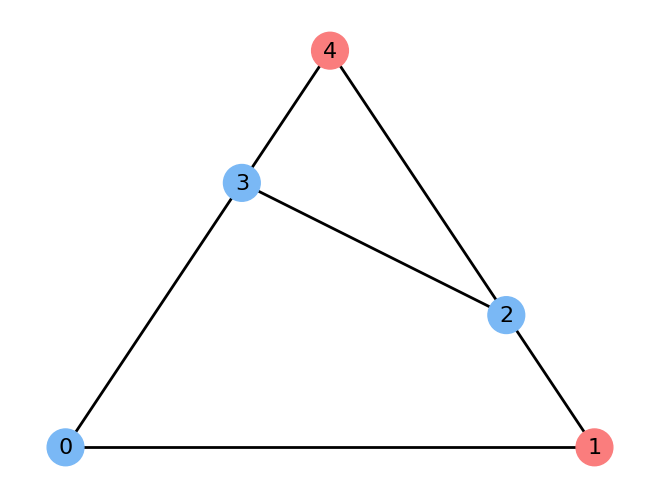

In [144]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.planar_layout(G))

## 10-vertices graph

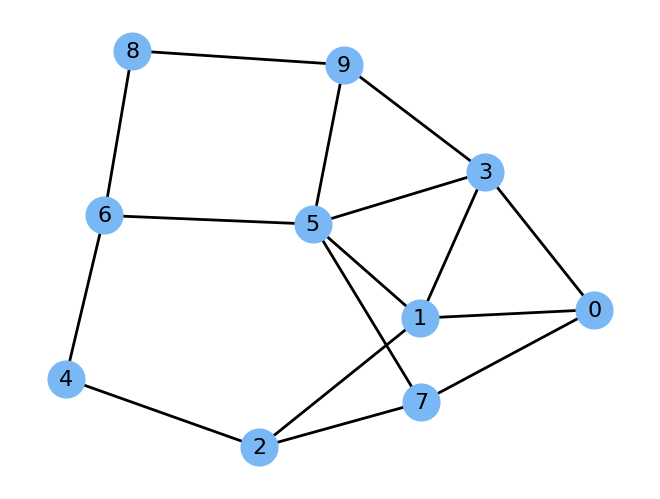

In [145]:
G = nx.Graph()
G.add_edges_from([[0, 1], [6, 8], [9, 8], [9, 5], [1, 2], [9, 3], [0, 3], [2, 4], [1, 3], [3, 5], [1,5], [5, 3], [6,5], [4,6], [7, 2], [7,5], [7, 0]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

In [146]:
result = minimize_cost_function(G, [2.647339, 3.90922])
frequencies = get_frequencies_for_optimal_cirquit(G, result)
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -10.557291666666666
       x: [ 2.792e+00  3.441e+00]
    nfev: 36
   maxcv: 0.0

In [147]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 0101100110 with cut size 13
Exact max cut size: 13
Average cut size from all executions:  10.53995


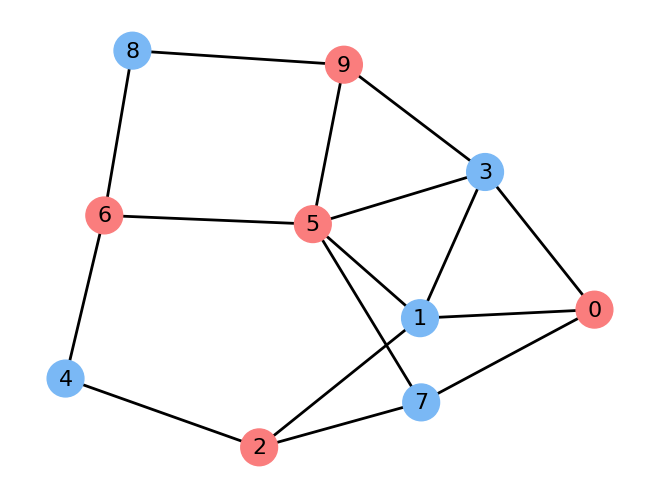

In [148]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

## 20-vertices graph

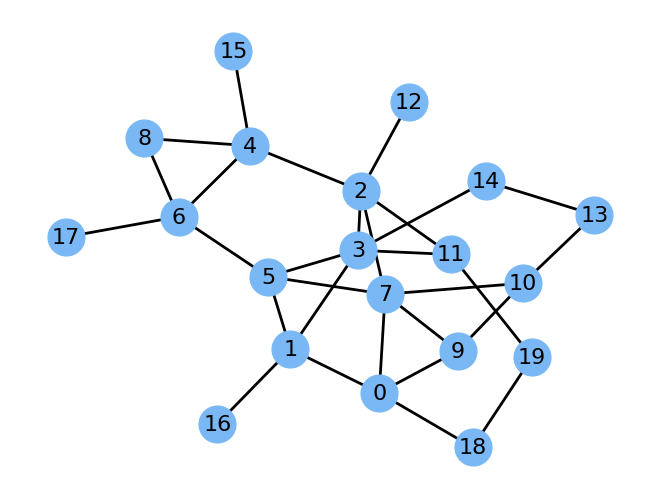

In [149]:
G = nx.Graph()
G.add_edges_from([[0, 1], [12, 2], [13, 10], [14, 13], [15, 4], [16, 1], [17, 6], [18, 0], [19, 18], [6, 8], [8, 4], [9, 7], [9, 0], [10, 9], [11,3], [11, 19], [10, 7], [11, 2], [2, 3], [14, 3], [2, 4], [1, 3], [3, 5], [1,5], [5, 3], [6,5], [4,6], [7, 2], [7,5], [7, 0]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

In [150]:
result = minimize_cost_function(G, [1.656452, 3.33238])
frequencies = get_frequencies_for_optimal_cirquit(G, result)
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -19.152994791666668
       x: [ 2.778e+00  3.452e+00]
    nfev: 37
   maxcv: 0.0

In [151]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 01010011110111010010 with cut size 24
Exact max cut size: 25
Average cut size from all executions:  19.10765


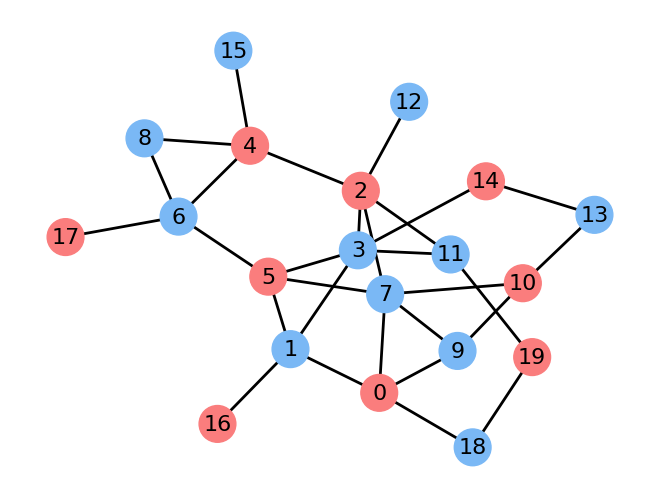

In [152]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

## 25-vertices graph


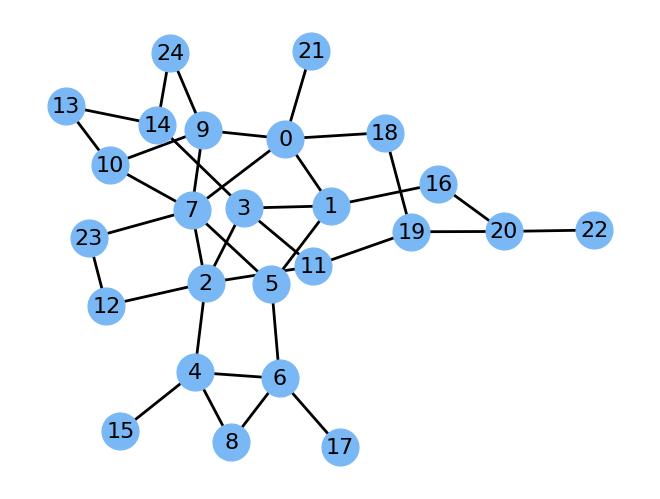

In [153]:
G = nx.Graph()
G.add_edges_from([[19,20], [20,16], [21,0], [22, 20], [23,12], [24, 14], [24,9], [0, 1], [12, 2], [13, 10], [14, 13], [15, 4], [16, 1], [17, 6], [18, 0], [19, 18], [6, 8], [8, 4], [9, 7],[7,23], [9, 0], [10, 9], [11,3], [11, 19], [10, 7], [11, 2], [2, 3], [14, 3], [2, 4], [1, 3], [1,5], [6,5], [4,6], [7, 2], [7,5], [7, 0]])
nx.draw(G, with_labels = True, node_color='#7ab8f5', width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))

In [154]:
result = minimize_cost_function(G, [1.57082, 2.83617])
frequencies = get_frequencies_for_optimal_cirquit(G, result)
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -24.083984375
       x: [ 3.913e-01  2.839e+00]
    nfev: 32
   maxcv: 0.0

In [156]:
maxcut_state = get_most_frequent_state(frequencies);
maxcut_cut = get_cut_size_from_state_string(G, maxcut_state)
print('QAOA best solution:', maxcut_state, 'with cut size', maxcut_cut)
print('Exact max cut size:', get_exact_maxcut(G, frequencies)[0])
print('Average cut size from all executions: ', -get_average_energy(G, frequencies))

QAOA best solution: 0101101101011100001011100 with cut size 30
Exact max cut size: 32
Average cut size from all executions:  24.03675


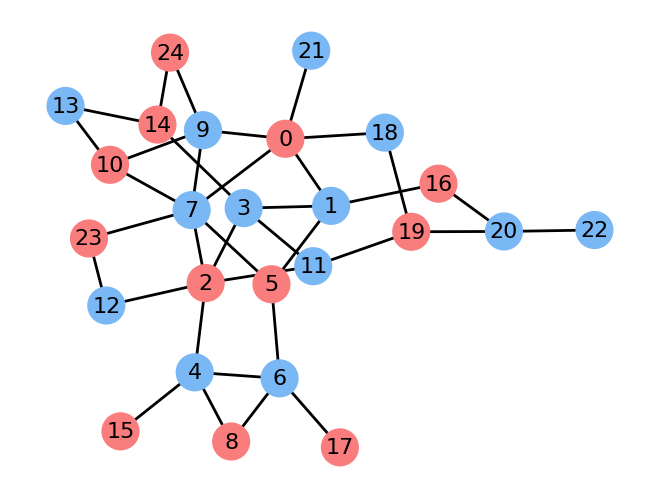

In [157]:
colors = ['#7ab8f5' if maxcut_state[node] == '1' else '#fa7d7d' for node in G]
nx.draw(G, with_labels = True, node_color=colors, width=2, font_size=16, node_size=700, pos=nx.kamada_kawai_layout(G))